In [ ]:
%reset

In [ ]:
pip install pyts matplotlib 

In [2]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support as score

import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM
from tensorflow.keras.models import Model


import random
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#M - months A - appliances N - num of imgs 

#file_name ="UKDALE_GAF_1h_18M9A1000N"
#file_name= "UKDALE_GAF_1h_12M10A300N"
#file_name = "UKDALE_GAF_1h_12M10A500N"
#file_name = "UK-DALE_GADF_60m_300S0X_9A5000N_NmB" # x is n of paralel imgs


#file_name = "test_REFIT+ECO+UKDALE+IAWE_GASF_13m100S10X"
file_name = "ALL_13m_100S5X"

dir_path =os.path.abspath(os.getcwd())

#check if we are in cloud or in PC<

try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS_UNZIPPED/"f"{file_name}"
    #path = "/content/drive/MyDrive/Colab Notebooks/NILM/GAF_DS/old2/"
except:
    print("reading from HDD")
    path = dir_path+"/data"

#check if file exists
try:
    file = h5py.File(f"{path}""/"f"{file_name}""/"f"{file_name}"".hdf5","r+")
    print("file exists, reading it...")
except:
    print("error reading the file!")


# function to make reading easier
def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.
    """
    images = []

    # Open the HDF5 file
    file = h5py.File(f"{path}""/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

reading from HDD
file exists, reading it...


In [5]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    

    plt.title(title)



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()

In [6]:
def LSTM_3D(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
 
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [7]:
def LSTM_3D_32(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [8]:
def LSTM_3D_32_7(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [9]:
def LSTM_3D_extra_LSTM(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=True, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [10]:
def LSTM_3D_extra_dense(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
   
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    out = Dense(32, activation='softmax')(out)
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [11]:
def LSTM_3D_base_layers(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a)
    
    x.trainable = False
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    x.trainable = False
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x.trainable = False
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x.trainable = False
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)
    
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    base_layers = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6
    
    return base_layers

In [12]:
def LSTM_Dense2(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(8, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(32, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)
    #out = Dense(16, activation = 'relu')(out)
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [13]:
def basic_cnn_functional(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(input_a)
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)
    
    
    
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = Flatten()(out)
    # dense layer with 50 neurons
    dense = Dense(64, activation = 'relu')(out)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [14]:
appliance_set = set()
appliance_instances = []
datasets = ["refit"]
for dataset in datasets:
      
    for appliance in file[dataset].keys():

        for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
            appliance_instances.append(appliance)
            appliance_set.add(appliance)

available_appliances = list(appliance_set)
print(available_appliances)

['broadband router', 'fridge freezer', 'audio system', 'washing machine', 'dish washer', 'microwave', 'electric space heater', 'dehumidifier', 'games console', 'breadmaker', 'fan', 'tumble dryer', 'computer', 'unknown', 'appliance', 'kettle', 'television', 'food processor', 'toaster', 'washer dryer', 'pond pump', 'fridge']


In [15]:
#refit
available_appliances.remove("fridge freezer")
available_appliances.remove("fan")
available_appliances.remove("toaster")

In [16]:
#redd
available_appliances.remove("electric stove")
available_appliances.remove("washer dryer")
available_appliances.remove("dish washer")
available_appliances.remove("electric oven")
available_appliances.remove("air conditioner")
available_appliances.remove("air handling unit")
available_appliances.remove("electric space heater")
available_appliances.remove("sockets")

ValueError: list.remove(x): x not in list

In [18]:
##load datastset for normal use
data = np.empty([0,5,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

datasets = ["refit"]
#datasets = ["eco","refit","ukdale", "iawe","redd"]
#datasets = ["refit","ukdale"]
appliances = []

num_of_buildings_arr = []
#for refit and eco
#appliances =  ['dish washer', 'fridge', 'fridge freezer', 'kettle',
#'microwave', 'television', 'toaster', 'washing machine', 'coffee maker',
#'computer', 'freezer', 'lamp', 'laptop computer']

#appliances = ['coffee maker', 'computer', 'freezer', 'fridge', 'lamp', 'laptop computer', 'dish washer', 'fridge freezer', 'kettle', 'microwave', 'television', 'toaster', 'washing machine', 'boiler', 'computer monitor', 'washer dryer']


#refit to train on 
#appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer"]
#datasets = ["eco","iawe","ukdale","redd"]

#eco to TL on
#datasets = ["eco"]
#appliances =["fridge","HTPC","kettle","laptop computer","coffee maker","lamp","computer","microwave"]


 #iawe to TL on
#datasets = ["iawe"]
#appliances = ["air conditioner","computer","fridge","television"]


# #redd to TL on 
#datasets = ["redd"]
#appliances = ["light","electric furnace","fridge","microwave"]


datasets = ["ukdale"]
appliances = ["light","laptop computer","computer monitor","desktop computer","television","dish washer","boiler"]
#'desktop computer',,, 'air conditioner', washer, dryer
# #appliances = [
#  'fridge',
#  'light',
#  'microwave']

faulty_redd_appliances = []#["air conditioner","washer dryer"]

#appliances = available_appliances 



for dataset in datasets:
  #check last len so that number of appliances is balanced
  
    for appliance in file[dataset].keys():
    
        #train on all available appliances from refit change for test
        if appliance in appliances:

            last_length = len(np.where(labels == appliances.index(appliance))[0])
            #num_of_buildings = 0
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
              #num_of_buidlings += 1

                if (len(np.where(labels == appliances.index(appliance))[0]) - last_length) < 4000:      

                    if dataset == "redd" and appliance in faulty_redd_appliances:
                            continue        
                    else:

                        N  = 1000
                        if appliance == "computer":
                            N = 500
                          #   N = 250 #for training
                         #N = -1
                        if appliance == "fridge":
                            N = 300 #for traingig
                         # N = -1

                        if appliance == "television":
                        #    N = 70 #for training
                            #N = 130
                            N = 300
                        if appliance == "washing machine":
                            #N = 70 #for training
    #                         N = 600
                            N = 300
                        if appliance == "washer dryer":
                            #N = 40
                             N = -1
                        if appliance == "microwave":
                            N = 250
                            #N = 90
                        if appliance == "toaster":
                            N = -1
                            N = 200
                        if appliance == "kettle":
                            N = 200
                            #N = 90
                        
                        N = 500
                        

                        #images = np.array()

                        images = file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'][0:N,...]
                        #images = images[N+1:-1,...]

                        data = np.append(data,images,axis=0)

                        array_of_labels = np.ones(images.shape[0])*appliances.index(appliance)
                        labels = np.append(labels,array_of_labels)

                        array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                        labels_ds = np.append(labels_ds,array_of_labels_ds)

                        #array_of_labels_buildings = np.ones(images.shape[0])*datasets.index(dataset)
                        #labels_buildings = 

                        print("dataset",dataset,"app",appliance,"bui",building,"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)
                else:
                    print("skipped appl: ",appliance," and dataset:",dataset," due to len: ",(len(np.where(labels == appliances.index(appliance))[0]) - last_length))
        

print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

dataset ukdale app boiler bui 1 shape (500, 5, 100, 100, 1) labels (500,) dsshape (500,)
dataset ukdale app boiler bui 4 shape (1000, 5, 100, 100, 1) labels (1000,) dsshape (1000,)
dataset ukdale app computer monitor bui 1 shape (1500, 5, 100, 100, 1) labels (1500,) dsshape (1500,)
dataset ukdale app computer monitor bui 2 shape (2000, 5, 100, 100, 1) labels (2000,) dsshape (2000,)
dataset ukdale app computer monitor bui 5 shape (2456, 5, 100, 100, 1) labels (2456,) dsshape (2456,)
dataset ukdale app desktop computer bui 1 shape (2802, 5, 100, 100, 1) labels (2802,) dsshape (2802,)
dataset ukdale app desktop computer bui 5 shape (3302, 5, 100, 100, 1) labels (3302,) dsshape (3302,)
dataset ukdale app dish washer bui 1 shape (3802, 5, 100, 100, 1) labels (3802,) dsshape (3802,)
dataset ukdale app dish washer bui 2 shape (3847, 5, 100, 100, 1) labels (3847,) dsshape (3847,)
dataset ukdale app dish washer bui 5 shape (3900, 5, 100, 100, 1) labels (3900,) dsshape (3900,)
dataset ukdale app

In [19]:
for i in range(len(appliances)):
  print(appliances[i],len(np.where(labels == i)[0]) )

light 500
laptop computer 1126
computer monitor 1456
desktop computer 846
television 1170
dish washer 598
boiler 1000


In [ ]:
#backup#if (skip_refit == int(building) and dataset == "refit") or (skip_redd == int(building) and appliance == "light" and dataset == "redd") or (skip_eco == int(building) and appliance == "HTPC" and dataset == "eco"):

In [ ]:
##load dataset hierar for trasfer learnng 
##script to read hierarchical format (used in colab)
data = np.empty([0,10,100,100,1])

labels = np.empty(0)
labels_ds = np.empty(0)

#datasets = ["iawe"]
datasets = ["eco","iawe","ukdale","refit","redd"]
appliances = ["computer","television","freezer","light","washing machine","HTPC","dish washer","coffee maker","computer monitor"]#,"microwave","kettle","toaster"]

#to train on refit and TL on all others
datasets = ["refit"]
datasets = ["eco","iawe","ukdale","redd"]
appliances = ["television","fridge","dish washer","kettle","toaster","microwave","computer","washing machine"]

class selection:
  def __init__(self,dataset, building, appliance):
    self.dataset = dataset
    self.building = building
    self.appliance = appliance
    
slct = []
slct.append(selection("refit",19,"computer"))
slct.append(selection("refit",19,"freezer"))
slct.append(selection("refit",19,"washing machine"))
slct.append(selection("refit",19,"television"))
slct.append(selection("refit",5,"microwave")) #was 12
slct.append(selection("refit",10,"dish washer"))#was 7 10
slct.append(selection("refit",11,"kettle")) # was 9 11
slct.append(selection("refit",2,"toaster")) # was 9 11
slct.append(selection("redd",4,"light"))
slct.append(selection("eco",5,"HTPC"))
slct.append(selection("eco",1,"coffee maker")) 
slct.append(selection("ukdale",1,"computer monitor")) 
i = 0

#loop through datasets
for dataset in datasets:

    #loop through appliances in dataset
    for appliance in file[dataset].keys():
        
        #in case it matches selected appliance
        if appliance in appliances:
            
            #loop through building for this dataset and this appliance
            for building in file[f"{dataset}""/"f"{appliance}""/"].keys():
                
                #check if appliance should be skipped and saved for later
                continue_flag = 0
                for e in slct:
                    if(e.dataset == dataset and e.building == int(building) and e.appliance == appliance):
                        print(dataset,building,appliance)
                        continue_flag = 1
                    
                if continue_flag == 1:
                    print("skipped buil ",building,"and dataset ",dataset," with appl",appliance," to save it for later")
                #    continue
                
                #else:

                    N = -1
                    if appliance == "computer":
                        N = 250 #for training
                     #N = -1
                    if appliance == "fridge":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "freezer":
                        N = 150 #for traingig
                     # N = -1
                    if appliance == "television":
                    #    N = 70 #for training
                        N = 130
#                     if appliance == "washing machine":
#                     #    N = 70 #for training
#                         N = 600
                    if appliance == "microwave":
                        N = 250
                        #N = 90
                    if appliance == "toaster":
                        N = 250
                        #N = 80
                    if appliance == "kettle":
                        N = 250
                        #N = 90

                    #N = 100

                    N = -1


                    images = np.array(file[f"{dataset}""/"f"{appliance}""/"f"{building}"]['gaf'])
                    images = images[0:N,...]
                    data = np.append(data,images,axis=0)

                    array_of_labels = np.ones(images.shape[0])*appliances.index(appliance)
                    labels = np.append(labels,array_of_labels)

                    array_of_labels_ds =  np.ones(images.shape[0])*datasets.index(dataset)
                    labels_ds = np.append(labels_ds,array_of_labels_ds)


                    print("dataset",dataset,"app",appliance,"bui",building,"shape",data.shape,"labels",labels.shape,"dsshape",labels_ds.shape)



print(np.unique(labels))
print("dataset: ",np.unique(labels_ds))

print(data.shape)
print(labels.shape)
print(labels_ds.shape)

print("appliances", appliances)
#print(labels)
#print([key for key in file["data"].keys()])

In [ ]:
#LOAD DATASET

#reading h5 file example
# file_name = "UKDALE_GAF_10m_100S10X_9A900N"
#file_name = "UK-DALE_13m_100S10X_9A5000N"
#file_name = "REDD_13m_100S10X_8A1500N"
# file_name = 'UK-DALE_RECU_10m_100S10X_9A150N'
# file_name = 'UK-DALE_GADF_13m_100S10X_9A5000N_YmB'
#file_name = 'UK-DALE_GASF_13m_100S10X_9A5000N_YmB'
#file_name="iAWE_GASF_13m_100S10X_5A5000N_Y-B_N-O_Y-S"

#read the file
#file = h5py.File(f"{file_name}"".hdf5","r+")
#fetch array of appliances
enc_appliances = np.array(file["classes/appliances"])
appliances = [n.decode("utf-8") for n in enc_appliances]
#manualy_selected_appliances.remove("microwave")

#fetch array of weights
class_weights = np.array(file["classes/weights"])
#class_weights = np.delete(class_weights,5)
print(appliances)

print(class_weights)

#read train and label data
X = data = np.array(file['data']['gasf'])
labels = np.array(file['labels']['gaf'])
labels_buildings = np.array(file["labels/building"])

#data = np.delete(X,np.where(labels == 5)[0][0],0)

#labels = np.delete(labels,np.where(labels == 5)[0][0],0)

#labels[np.where(labels == 6)] = 5
print(np.unique(labels))

print(data.shape)
print(labels.shape)
#print(labels)
print([key for key in file["data"].keys()])

In [ ]:
X_train = 0
X_test = 0
y_train = 0
y_test = 0


In [ ]:
del images
del array_of_labels_ds
del data

In [ ]:
#Convert classes to onehot encoding

# manualy_selected_appliances= ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
num_of_classes = len(appliances)  # 
print(appliances)
print(num_of_classes)

y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

In [ ]:
#Split data on training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=12, stratify=y_anomF)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
y_train[0]
data = 0;

In [ ]:
#copy model for refrence later 
model_copy= keras.models.clone_model(model)
model_copy.build((None, X_train.shape[1: ])) # replace 10 with number of variables in input layer
lr = 0.00002
adam = optimizers.Adam(lr = lr)
model_copy.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_copy.set_weights(model.get_weights())

In [20]:
#path_model = dir_path+"/models/auto_classic/model_0"
path_model = dir_path+"/models/model_classic3"
#path_model = dir_path+"/models/gen/model_gen"
model = keras.models.load_model(path_model)

2021-10-22 05:52:36.828887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-22 05:52:36.829695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-10-22 05:52:36.830057: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-10-22 05:52:37.675226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-10-22 05:52:37.675259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-10-22 05:52:37.675284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-10-22 05:52:37.676483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

In [ ]:
model_used = model2

In [ ]:
#create trasfer learning model 
model.trainable = False
base_output = model.layers[-2].output
#hidden4 = Dense(64, activation='softmax')(base_output)
hidden3 = Dense(32, activation='softmax')(base_output)
hidden2 = Dense(16, activation='softmax')(hidden3)
hidden = Dense(num_of_classes, activation='softmax')(hidden2)

model2 = keras.models.Model(model.inputs, hidden)
lr = 0.002
adam = optimizers.Adam(lr = lr)
model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [ ]:
## Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
model = LSTM_3D(X_train,num_of_classes,lr = 0.00002) #00

In [ ]:
model_used = model2

model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 30, verbose = 2)
results = model_used.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

In [ ]:
# path_model_classic = dir_path+"/models/model_classic3"
# model_used.save(path_model_classic)

In [ ]:
model_used.summary()

In [ ]:
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
#f1_per_fold.append(round(fscore,4))


42/42 - 0s
[[  0   1   1  34  19  30  15]
 [  0 178  15   2  14   1  15]
 [  0   8 251   0  19   0  14]
 [  0   0   0 150  16   1   2]
 [  0   3  44  17 152   0  18]
 [  0   0   0   0   1 118   1]
 [  0   2  18   1  29   0 150]]
F1 SCORE 0.6702064250699945
Normalized confusion matrix
                  precision    recall  f1-score   support

           light       0.00      0.00      0.00       100
 laptop computer       0.93      0.79      0.85       225
computer monitor       0.76      0.86      0.81       292
desktop computer       0.74      0.89      0.80       169
      television       0.61      0.65      0.63       234
     dish washer       0.79      0.98      0.87       120
          boiler       0.70      0.75      0.72       200

        accuracy                           0.75      1340
       macro avg       0.65      0.70      0.67      1340
    weighted avg       0.70      0.75      0.72      1340



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

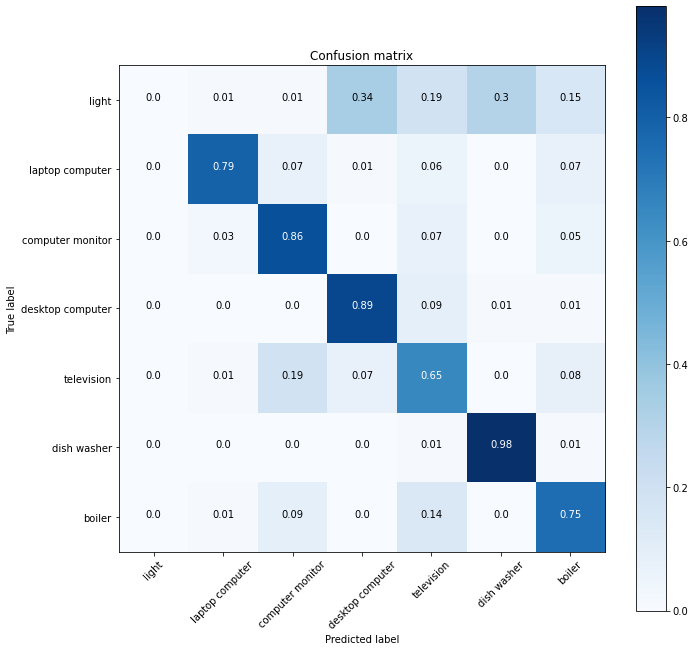

In [67]:
#Print results and plot confusion matrix

#print('Test accuracy: ', results[1])
#print("Loss: "f"{results[0]}")
Y_pred = model_used.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
C = confusion_matrix(Y_test, y_pred)
# B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
print(confusion_matrix(Y_test, y_pred))
precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
print("F1 SCORE",fscore)
plot_confusion_matrix_norm(C, appliances, normalize=True)
print(classification_report(Y_test, y_pred, target_names=appliances))

In [ ]:
#kfold with random seed
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []
seed_per_fold = []

for seed in range(10,500,5):
    #print("TRAIN:", train_index, "TEST:", test_index)
        
    X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=seed, stratify=y_anomF)
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 0)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    precision_per_fold.append(round(precision,4))
    recall_per_fold.append(round(recall,4))
    seed_per_fold.append(seed)


    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    print('test f1: ',f1_per_fold[-1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, random_state=12)
data = 0;
labels = 0
X_train_2, _, y_train_2, _ = train_test_split(X_train, y_train, test_size=.2, random_state=12, stratify=y_train)

In [ ]:
num_of_classes = len(appliances)  
print(appliances)
print(num_of_classes)

#y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

In [ ]:
#counts_arr = []

counts_arr.append(counts)
print(counts_arr[1])

In [ ]:
percent_arr = [0.01,0.02,0.03,0.04,0.05,0.07,0.10,0.20, 0.30, 0.50]
counts_arr = []

values, counts = np.unique(y_train_not_hot, return_counts=True)
print(len(values),counts_arr.append(counts))

for percent in percent_arr:
    X_train_2, _, y_train_2, _ = train_test_split(X_train, y_train_not_hot, train_size=percent, random_state=12, stratify=y_train_not_hot)
    values, counts = np.unique(y_train_2, return_counts=True)
    print(len(values),counts_arr.append(counts))
    X_train_2 = 0
    y_train_2 = 0

In [ ]:
X_train[train_rand_inx].shape

In [ ]:
train_rand_inx = []
while len(train_rand_inx) < 100 :
    choice = random.choice(np.where(y_train_not_hot == 0)[0])
    if choice in train_rand_inx:
        continue
    else:
        train_rand_inx.append(choice)

In [ ]:
np.array(train_rand_inx).shape

In [ ]:
X_train.shape

In [ ]:
np.where(y_train_not_hot != 1)[0].shape

In [ ]:
train_2_indexes = np.append(np.where(y_train_not_hot != 1)[0],np.array(train_rand_inx))

In [ ]:
a = np.random.randint(0,np.where(y_train_not_hot == 1)[0])
a = np.array(train_rand_inx)
print(a.shape)
print(np.unique(a).shape)

In [55]:
np.unique(y_train_not_hot[index_selected_appl],return_counts=True)

(array([0.]), array([400]))

In [71]:
type(X_train_2).meta

AttributeError: type object 'numpy.ndarray' has no attribute 'meta'

In [61]:
X_train.shape

(5356, 5, 100, 100, 1)

In [65]:
X_train[index_merged].shape

(5356, 5, 100, 100, 1)

In [59]:
np.unique(y_train_not_hot[index_merged],return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([ 400,  901, 1164,  677,  936,  478,  800]))

In [83]:
np.unique(y_train_not_hot[:],return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([ 400,  901, 1164,  677,  936,  478,  800]))

In [81]:
y_train_not_hot[[200,250,300]]

array([3., 2., 4.])

In [82]:
y_train[[200,250,300]]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [91]:
n = 700

print(y_train_not_hot[index_merged][n])
print(y_train_not_hot[:][n])

4.0
3.0


In [ ]:
appliance_index = 0
index_selected_appl = []

    while len(index_selected_appl) < percent :
        choice = random.choice(np.where(y_train_not_hot == appliance_index)[0])
        if choice in index_selected_appl:
            continue
        else:
            index_selected_appl.append(choice)

index_selected_appl = np.where(labels == appliance_index)[0]    
a = np.array(index_selected_appl)
print("instances in array",a.shape)
print("unique instances",np.unique(a).shape)
#get indexes from appliances that is not selected
index_all_other_appl = np.where(labels != appliance_index)[0]
#append all appliances and n selected indexes
index_merged = np.append(index_all_other_appl,np.array(index_selected_appl))
#use indexes to select data
X_train_2 =X_train[:]#index_merged]
y_train_2 = y_train[:]#index_merged]
values, counts = np.unique(y_train_not_hot[index_merged], return_counts=True)#[index_merged]

In [92]:
## test dependecy of number of samples to performace 

#define prec, recall and F1 for each class
prec0, prec1, prec2, prec3, prec4, prec5, prec6 = ([] for i in range(7))
precission = [prec0, prec1, prec2, prec3, prec4, prec5, prec6]
rec0, rec1, rec2, rec3, rec4, rec5, rec6 = ([] for i in range(7))
recall = [rec0, rec1, rec2, rec3, rec4, rec5, rec6]
F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6 = ([] for i in range(7))
F1 = [F1_0, F1_1, F1_2, F1_3, F1_4, F1_5, F1_6]

#counts arr
counts_arr = []

#main split

num_of_classes = len(appliances)
#data = 0;
#labels = 0

#one hot encoding
y_train = tf.keras.utils.to_categorical(y_train_not_hot, num_classes=num_of_classes)
y_test = tf.keras.utils.to_categorical(y_test_not_hot, num_classes=num_of_classes)


#percent_arr = [0.01,0.02,0.03,0.04,0.05,0.07,0.10,0.20, 0.30, 0.50,0.99]
#percent_arr = [0.20, 0.30, 0.50]

percent_arr = range(10,5000,50)
percent_arr = [400]
appliance_index = 0

for percent in percent_arr:
    
    #split all
    print("splitting train size %",percent)
    #X_train_2, _, y_train_2, _ = train_test_split(X_train, y_train_not_hot, train_size=percent, random_state=12, stratify=y_train_not_hot)
    #values, counts = np.unique(y_train_2, return_counts=True)
    
    #split for only one appliance
    
    #get N random images for one aplliance
    index_selected_appl = []
#     while len(index_selected_appl) < percent :
#         choice = random.choice(np.where(y_train_not_hot == appliance_index)[0])
#         if choice in index_selected_appl:
#             continue
#         else:
#             index_selected_appl.append(choice)
    
    index_selected_appl = np.where(y_train_not_hot == appliance_index)[0]    
    a = np.array(index_selected_appl)
    print("instances in array",a.shape)
    print("unique instances",np.unique(a).shape)
    #get indexes from appliances that is not selected
    index_all_other_appl = np.where(y_train_not_hot != appliance_index)[0]
    #append all appliances and n selected indexes
    index_merged = np.append(index_all_other_appl,np.array(index_selected_appl))
    #use indexes to select data
    X_train_2 =X_train[:]#index_merged]
    y_train_2 = y_train[:]#index_merged]
    values, counts = np.unique(y_train_not_hot[index_merged], return_counts=True)#[index_merged]
        
    print("appending counts :",counts)
    counts_arr.append(counts)
    
    X_train, X_test, y_train, y_tes = train_test_split(data, labels, test_size=.2, random_state=42,stratify=labels)
   
    #reset model and compile it again
    model.trainable = False
    base_output = model.layers[-2].output
    #hidden4 = Dense(64, activation='softmax')(base_output)
    hidden3 = Dense(32, activation='softmax')(base_output)
    hidden2 = Dense(16, activation='softmax')(hidden3)
    hidden = Dense(num_of_classes, activation='softmax')(hidden2)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.002
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    print("xt2",X_train_2.shape)
    print("yt2",y_train_2.shape)
    model_used = model2
    model_used.fit(X_train_2, y_train_2, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])
    
    Y_pred = model_used.predict(X_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    
    #Calculate metrics. IMPORTANT use labels that the scores will be correct for each class
    metrics = score(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])
    
    #del model_used
    #del model2
    
    #append prec, rec and F1 for each individual class
    for k,j in enumerate(precission):
        j.append(metrics[0][k])

    for k,j in enumerate(recall):
        j.append(metrics[1][k])

    for k,j in enumerate(F1):
        j.append(metrics[2][k])

splitting train size % 400
instances in array (400,)
unique instances (400,)
appending counts : [ 400  901 1164  677  936  478  800]
xt2 (5356, 5, 100, 100, 1)
yt2 (5356, 7)


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
536/536 - 6s - loss: 1.8072 - accuracy: 0.3198 - val_loss: 1.5743 - val_accuracy: 0.4580
Epoch 2/15
536/536 - 4s - loss: 1.3642 - accuracy: 0.4762 - val_loss: 1.2211 - val_accuracy: 0.4804
Epoch 3/15
536/536 - 4s - loss: 1.1344 - accuracy: 0.5796 - val_loss: 1.0464 - val_accuracy: 0.6157
Epoch 4/15
536/536 - 4s - loss: 1.0054 - accuracy: 0.6102 - val_loss: 0.9623 - val_accuracy: 0.6147
Epoch 5/15
536/536 - 4s - loss: 0.9379 - accuracy: 0.6408 - val_loss: 0.9113 - val_accuracy: 0.6465
Epoch 6/15
536/536 - 4s - loss: 0.8806 - accuracy: 0.6683 - val_loss: 0.8743 - val_accuracy: 0.6642
Epoch 7/15
536/536 - 4s - loss: 0.8523 - accuracy: 0.6720 - val_loss: 0.8529 - val_accuracy: 0.6782
Epoch 8/15
536/536 - 4s - loss: 0.8321 - accuracy: 0.6851 - val_loss: 0.8243 - val_accuracy: 0.7062
Epoch 9/15
536/536 - 4s - loss: 0.7864 - accuracy: 0.7106 - val_loss: 0.7987 - val_accuracy: 0.7155
Epoch 10/15
536/536 - 4s - loss: 0.7736 - accuracy: 0.7213 - val_loss: 0.7854 - val_accuracy: 0.7211

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
np.array(counts_arr)[:,0]

In [ ]:
for i,e in enumerate(appliances):
    print(i,e)
    plt.plot(np.array(counts_arr)[:,i], precission[i], '-o')
    plt.ylabel("F1")
    plt.xlabel("samples")
    plt.show()

In [ ]:
#automating model generation for various types of models 
i = 0
model_names = [LSTM_3D_32(X_train,num_of_classes,lr = 0.00002),LSTM_3D_extra_dense(X_train,num_of_classes,lr = 0.00002),LSTM_3D_extra_LSTM(X_train,num_of_classes,lr = 0.00002),LSTM_3D_32_7(X_train,num_of_classes,lr = 0.00002)]

for model in model_names:
      
    model_used = model
    model_used.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 150, verbose = 2)
    results = model_used.evaluate(X_test, y_test, verbose = 2)
    print('Test accuracy: ', results[1])
    
    path_model_classic = dir_path+"/models/auto_classic/model_"+str(i)
    model_used.save(path_model_classic)
    i += 1
    
    print("removing model from ram")
    del model_used
    del model
    print("new model")

In [ ]:
import gc

gc.collect()

In [ ]:
mode_used

In [ ]:
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

# KFOLD

In [ ]:
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []

# X_train, X_test, y_train, y_test = train_test_split(data, y_anomF, test_size=.2, random_state=42)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
# y_train[0]

#y_anomF = tf.keras.utils.to_categorical(labels, num_classes=num_of_classes)

skf = StratifiedKFold(n_splits=5,shuffle=False)
print("num of splits:",skf.get_n_splits(data))

for train_index, test_index in skf.split(data, labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
#     train_l = []
#     test_l = []
    
#     for n in range(num_of_classes):
#         train_l.append(len(y_train[y_train==n]))
#         test_l.append(len(y_test[y_test==n]))
    
#     print('>Train:', (train_l),"all",sum(train_l))
#     print('>test:', (test_l),"all",sum(test_l))


    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_of_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
    
    
    
    #Load model (LSTM_3D is the one that worked the best), set learning rate and number of classes (final layer length), then train the data (change epoch for more training cycles)
    #model = LSTM_3D(X_train,num_of_classes,lr = 0.00002)
    
    model.trainable = False
    base_output = model.layers[-2].output
    hidden = Dense(num_of_classes, activation='softmax')(base_output)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.02
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    
    #print(model.summary())
    # model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 15, verbose = 2)
    model2.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 40, verbose = 1)
    results = model2.evaluate(X_test, y_test, verbose = 2)
    
    precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    
    f1_per_fold.append(round(fscore,4))
    acc_per_fold.append(round(results[1] * 100,4))
    loss_per_fold.append(round(results[0],4))
    
    
    print('Test accuracy: ',acc_per_fold[-1])
    print('Test loss: ',loss_per_fold[-1])
    

In [ ]:
model2.summary()

In [ ]:
acc_stat = f1_per_fold

In [ ]:
len(acc_stat)

In [ ]:
count = 0
for i in range(10,500,5):
    count +=1
    if count == 36:
        print(i)

In [ ]:
np.std(acc_stat)

In [ ]:
acc_stat.sort()

In [ ]:
for element in acc_stat:
    print(element*100)

In [ ]:
f1_per_fold

In [ ]:
#print(np.mean(acc_per_fold))
print(np.mean(recall_per_fold))

In [ ]:
y_train[0]

# Testing LSTM

In [ ]:
#User LSTM_Dense2 to change parameters of different models so that you live lstm34 intact. Otherwise the same as upper training method

model = LSTM_Dense2(X_train,num_of_classes,lr = 0.001)
print(model.summary())
model.fit(X_train, y_train, batch_size = 8, validation_split = 0.2, epochs = 20, verbose = 2)
results = model.evaluate(X_test, y_test, verbose = 2)
print('Test accuracy: ', results[1])

In [ ]:
print('Test accuracy: ', results[1])
print("Loss: "f"{results[0]}")
Y_pred = model.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=appliances))